# Лабораторная работа
## Ранжирование с помощью ML


![](https://avatars.mds.yandex.net/get-research/1677227/2a00000168a82fc9b0eac19e430b8454a656/orig)


Одна из отличительных особенностей задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса, т.е. важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно других документов.

### Подходы к решению задачи ранжирования
Существуют 3 основных подхода к ранжированию, различие между которыми заключается в том, на какую функцию потерь они опираются:
  
1. **Поточечный подход (pointwise)**. В этом подходе предполагается, что каждой паре запрос-документ поставлена в соответствие численная оценка. Задача обучения ранжированию сводится к построению регрессии: для каждой отдельной пары запрос-документ необходимо предсказать её оценку.

2. **Попарный подход (pairwise)**. В таком подходе обучение ранжированию сводится к построению бинарного классификатора, которому на вход поступают два документа, соответствующих одному и тому же запросу, и требуется определить, какой из них лучше. Другими словами, функция потерь штрафует модель, если отранжированная этой моделью пара документов оказалась в неправильном порядке.

3. **Списочный подход (listwise)**. Его суть заключается в построении модели, на вход которой поступают сразу все документы, соответствующие запросу, а на выходе получается их перестановка.


Будем использовать самый простой подход - поточечный.

### Оценка качества

Для оценивания качества ранжирования найденных документов в поиске традиционно используется метрика *DCG* ([Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)) и ее нормализованный вариант — *nDCG*, всегда принимающий значения от 0 до 1.

Для одного запроса DCG считается следующим образом:
$$ DCG(Q) = \sum_{i=1}^{numpos}\frac{(2^{rel_i} - 1)}{\log_2(i+1)}, $$
где
>$numpos$ — количество документов в поисковой выдаче, среди которых мы оценимваем качество (например, в предудыщих заданиях *num_pos* был равен 5)  
$rel_i$ — оценка релевантности документа, находящегося на i-той позиции   
   

Нормализованный вариант *nDCG* получается делением *DCG* на максимальное из его значений:

$$nDCG = \frac{DCG}{IDCG} \in [0, 1].$$
> *IDCG* — наибольшее из возможных значение *DCG* 






Чтобы оценить значение *nDCG* на выборке $Queries$ ($nDCG_{Queries}$) размера $N$, необходимо усреднить значение *nDCG* по всем запросам  выборки:
$$nDCG_{Queries} = \frac{1}{N}\sum_{q \in Queries}nDCG(q).$$

Пример реализации метрик ранжирование на python можно найти [здесь](https://gist.github.com/mblondel/7337391).

# Погнали
###  **Задача: предсказать оценку релевантности для запросов тестового датасета**


Мы будем работать на данных с конкурса [Интернет-математика 2009](https://academy.yandex.ru/events/data_analysis/grant2009/). По ссылке можно прочитать описание данных.      

Данные
> Данные разбиты на две выборки – обучающая выборка imat2009_learning.txt с известными оценками близости запроса и документа и тестовая выборка с неизвестными близостями imat2009_test.txt  

Обучающая выборка
> Данные для обучения содержат **97 290 строк**, которые соответствуют **9 124 запросам**  
Каждая строка соответствует паре «запрос-документ»    

Признаки
>Каждой паре «запрос-документ» соответствуют значения **245 признаков**. Формат хранения feat_num:value. Если значение признака равно 0, то он опускается.     
В комментариях в конце каждой строки указан **идентификатор запроса**.   
Файл с обучающей выборкой содержит **оценку релевантности**, значения из диапазона **[0, 4]** (4 – «высокая релевантность», 0 – «нерелевантно»).   


### DATA

In [3]:
# LOAD TRAIN DATA
file_learning = 'imat2009_learning.txt'

with open(file_learning) as f:
    train_data = f.readlines()
    
    
# LOAD TEST DATA
file_test = 'imat2009_test.txt'

with open(file_test) as f:
    test_data = f.readlines()


In [4]:
len(train_data), len(test_data)

(97290, 115643)

Структура данных следующая - первый элемент в строке - это оценка близости запроса и документа, дальше идут признаки документа, а последний элемент строки - это id запроса:

> RELEVANCE      feature:value feature:value ... feature:value     # QUERY_ID

In [5]:
train_data[:3]

['1 1:0.000023 7:0.704953 8:0.550315 9:0.032294 11:0.712631 14:0.015686 15:0.137255 16:0.302576 17:1.000000 18:0.996078 22:1.000000 23:1.000000 24:1.000000 27:0.700000 28:0.587629 29:0.999881 30:0.032294 34:0.000023 36:0.431373 37:0.002247 38:0.054902 41:1.000000 46:0.002247 50:0.032294 51:0.325613 52:0.056641 53:0.820677 54:0.388235 55:0.450980 56:0.312547 57:0.004672 59:1.000000 61:0.000023 65:1.000000 68:0.712195 69:0.001400 70:1.000000 71:0.001013 73:0.709459 74:0.560784 76:0.142857 77:0.360800 78:1.000000 79:1.000000 80:1.000000 82:0.000023 83:1.000000 85:0.996078 86:0.070588 87:1.000000 88:0.999797 92:1.000000 93:0.714286 95:0.039216 97:0.000023 98:0.356490 99:0.165041 102:1.000000 103:1.000000 104:1.000000 105:0.486275 108:0.152941 120:0.996078 121:0.676507 122:0.032294 126:0.712980 128:0.121569 129:0.609261 132:1.000000 134:0.109804 135:0.030535 140:0.002247 142:0.698039 144:0.248111 145:0.356490 146:1.000000 147:0.498039 148:0.125490 150:0.704953 151:1.000000 152:0.098039 154:

В test_data все оценки релевантности скрыты, поскольку этот набор данных использовался для проверки качества работы алгоритма в конкурсе. Нам эти данные не нужны, дальше работаем только с **train_data**.

Для проверки качества будущей модели надо разбить обучающую выборку на обучение и валидацию в соотношении 70 / 30

Внимание: разбивать необходимо **множество запросов QUERY_ID**, а не строчки датасета, чтобы в выборке находилась вся информация по запросу

Для этого вам надо:
1. собрать все запросы для каждого QUERY_ID

```
{
query_id : [
    RELEVANCE feature:value ... feature:value,
    ...
],
...
}
```

При этом я бы сразу собирала не сами данные, а номер строки в матрице данных
```
{
query_id : [
    line_num, line_num, ... line_num
],
...
}
```
2. собрать матрицу данных, размер вектора равен числу признаков = 245
```
data = np.zeros((len(train_data), feats_num), dtype=np.float32) 
```

3. собрать вектор с оценками релевантности, его размер равен размеру train_data

In [6]:
import numpy as np
import pandas as pd
from collections import defaultdict

labels = [] 
queries_lines_info = defaultdict(list) 

train_data = train_data
data = np.zeros((len(train_data), 245), dtype=np.float32) 

#YOUR CODE HERE
for i, line in enumerate(train_data):
    line_data = line.split(' ')
    
    label = float(line_data[0])
    query_id = int(line_data[-1])
    
    labels.append(label)
    queries_lines_info[query_id].append(i)
    
    for feat_data in line_data[1:-2]:
        feat_id, feat_value = feat_data.split(':')
        feat_id = int(feat_id)-1
        
        data[i, feat_id] = feat_value


In [7]:
data = np.zeros((len(train_data), 245), dtype=np.float32) 

for i, line in enumerate(train_data):
    #print(line)
    line_data = line.split(' ')
    feat_line_data = [feature.split(':') for feature in line_data[1:len(line_data)-2]]
    #print(feat_line_data)
    for feat in feat_line_data:
        data[i][int(feat[0])-1] = feat[1]


In [8]:
relevance_vector = np.array([line[0] for line in train_data])

In [9]:
len(train_data)

97290

In [11]:
assert data.shape == (len(train_data), 245)
assert len(queries_lines_info.keys()) == 9124
assert len(labels) == len(train_data)

In [12]:
queries_lines_info.keys()

dict_keys([3382, 11800, 21991, 19719, 11542, 11546, 11547, 11544, 14472, 8090, 11549, 3483, 19399, 5982, 5980, 5981, 22265, 22268, 19710, 10613, 1684, 19714, 11938, 6797, 6793, 6790, 13637, 11878, 13419, 1963, 21077, 18362, 11545, 16708, 16255, 16707, 16258, 16701, 22485, 22487, 12018, 12015, 12014, 14475, 12013, 12380, 17250, 17251, 17252, 17254, 17257, 10709, 9259, 9254, 15954, 10418, 21616, 21611, 21610, 21612, 934, 476, 12764, 20803, 19396, 20679, 10619, 4645, 21379, 5986, 17015, 19392, 10618, 14729, 3510, 14262, 3516, 2688, 2684, 2685, 14728, 2680, 2683, 14620, 14629, 99, 90, 97, 13058, 9287, 13052, 13053, 13051, 18702, 18701, 18706, 18709, 18708, 17829, 17828, 17827, 17826, 17825, 17824, 17820, 20258, 20251, 21071, 1177, 3438, 1175, 1173, 1172, 1179, 6263, 13443, 19707, 512, 21737, 7188, 7189, 7181, 7183, 7186, 7187, 16881, 14479, 621, 12831, 8019, 8013, 15282, 7455, 7452, 7453, 7451, 7458, 4848, 4849, 7486, 4595, 13601, 10884, 10886, 10888, 22671, 15007, 4599, 8290, 12593, 8293,

Разделим запросы из *queries_lines_info.keys()* на обучающую *train_queries_ids* и валидационную выборки *test_queries_ids* (70/30)

In [13]:
from sklearn.model_selection import train_test_split

#YOUR CODE HERE
train_queries_ids, test_queries_ids = train_test_split(list(queries_lines_info.keys()), test_size=0.3, random_state=42)


In [14]:
len(queries_lines_info.keys())

9124

In [15]:
# check
assert len(train_queries_ids) / (len(train_queries_ids) + len(test_queries_ids)) == 0.6999123191582639

 > Теперь у нас есть:  
 1) айдишники запросов для обучения и валидации **queries_id_train, queries_id_test**   
 2) матрица данных **data**   
 3) словарь **queries** с информацией о том, какие строчки в этой матрице соответствуют какому айдишнику  
 
 С помощью этих данных разделите матрицу data на матрицы **X_train, y_train, X_test, y_test**

In [148]:
# изи пизи способ получить несколько строк матрицы по их id данные матрицы
data_example = np.array(
    [
        [0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]
    ]
)

data_example[[0, 3]]

array([[0, 0, 0],
       [3, 3, 3]])

In [16]:
# разбиваем номера строк исходной матрицы на train и test

train_queries_lines_info = []
test_queries_lines_info = []

for query_id in train_queries_ids:
    train_queries_lines_info += queries_lines_info[query_id]
    
for query_id in test_queries_ids:
    test_queries_lines_info += queries_lines_info[query_id]

labels = np.array(labels)

X_train, y_train = data[train_queries_lines_info], labels[train_queries_lines_info]
X_test, y_test = data[test_queries_lines_info], labels[test_queries_lines_info]

In [17]:
train_queries_lines_info = np.array(train_queries_lines_info)
test_queries_lines_info = np.array(test_queries_lines_info)

In [18]:
test_queries_lines_info

array([32350, 32351, 32352, ..., 20134, 54569, 54570])

In [19]:
assert X_train.shape == (68418, 245) 
assert len(y_train) == 68418

Поздравляю, если вы все сделали до этого моменты, вы восхитительны! 

Данные готовы, можно заряжать модели                                                           
Для оценивания качества моделей используйте метрику nDCG, реализованную ниже

In [24]:
import metrics

def get_nDCG_score(queries, queries_lines_info, test_queries_lines_info, labels_true, labels_predicted):
    nDCG_scores = [] # nDCG по каждому запросу
    
    for query in queries:
        
        query_lines = queries_lines_info[query]
        
        query_lines_in_testdata = [np.where(test_queries_lines_info==line)[0][0] for line in query_lines]
                                            #test_queries_lines_info==line)[0][0]
        
        query_labels_true = labels[query_lines]
        query_labels_pred = labels_predicted[query_lines_in_testdata]
        
        nDCG = metrics.ndcg_score(query_labels_true, query_labels_pred, k=10)
        nDCG_scores.append(nDCG)
        
    nDCG_Queries = np.sum(nDCG_scores) / len(queries) # усредняем по всем запросам
    return nDCG_Queries


### FIT PREDICT

Воспользовавшись известными вам техниками построения линейной регрессии, обучите модель, предсказывающую оценку асессора

``` from sklearn.linear_model import LinearRegression``` 

In [21]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_y_pred = lin_reg.predict(X_test)

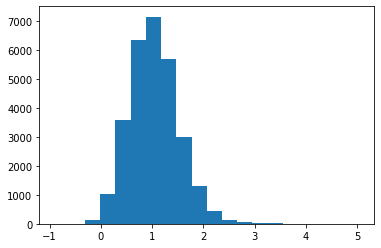

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

h = plt.hist(lin_reg_y_pred, bins=20)

Посчитаем качество модели по метрике **nDCG**

In [25]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lin_reg_y_pred
)

score_lin_reg

0.8282073539451125

Давайте теперь решим эту задачу не как регрессию, а как классификацию

In [26]:
from sklearn.svm import LinearSVC

linSVC = LinearSVC()
linSVC.fit(X_train, y_train)

linSVC_y_pred = linSVC.predict(X_test)

ValueError: Unknown label type: 'continuous'

кажется, наши классы не очень подходят для такой задачи - их очень много, и вот он пишет, что это похоже на continuous значения, а не бинарные, допустим

#### Ранжируем с RandomForestRegressor

In [27]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

rfr_y_pred = rfr.predict(X_test)


c:\users\maria\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


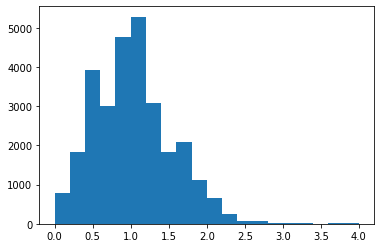

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

h = plt.hist(rfr_y_pred, bins=20)

In [31]:
score_rfr = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = rfr_y_pred
)

score_rfr

0.8233867422638672

#### Ранжируем с XGBoost

In [35]:
import xgboost

train_set, test_set = xgboost.DMatrix(X_train, label=y_train), xgboost.DMatrix(X_test, label=y_test)


In [37]:
xg_reg = xgboost.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)


In [39]:
xg_reg.fit(X_train,y_train)

xgb_y_pred = xg_reg.predict(X_test)

[23:35:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
score_xgb = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = xgb_y_pred
)

score_xgb

0.832963507246354

#### Ранжируем с LightGBM

с этим алгоритмом вышло лучше всего!

In [46]:
import lightgbm as lgb

train_set, test_set = lgb.Dataset(X_train, label=y_train), lgb.Dataset(X_test, label=y_test)


In [50]:
lgb_model = lgb.train({'num_leaves':30, 'max_depth':5}, train_set)

In [51]:
lgb_y_pred = lgb_model.predict(X_test)

In [52]:
score_lgb = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lgb_y_pred
)

score_lgb

0.8509849493330763